# Tutorial 1: Ship Data Analysis

This tutorial covers: 
1. Loading movement data from common geospatial file formats (that are supported by GeoPandas)
1. Converting GeoDataFrames into Trajectories describing continuous tracks of moving objects
1. Visualizing trajectories and their properties
1. Filtering trajectories by area of interest
1. Splitting continuous tracks into individual trips
1. Exploring trip properties including: origins, destinations, and attributes 

This tutorial AIS uses data published by the Danish Maritime Authority. The AIS record sample extracted for this tutorial is located near Gothenburg and covers the 5th July 2017.

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import movingpandas as mp
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## Area of interest: Gothenburg

Using zoom level 12, this will download 16 tiles
Wall time: 888 ms


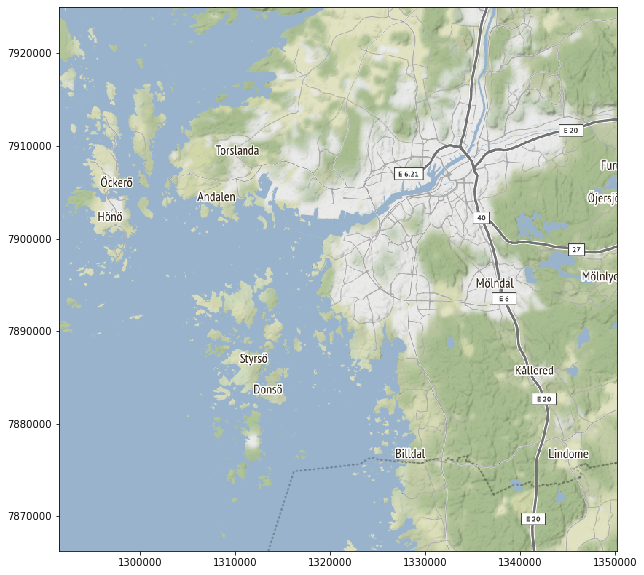

In [3]:
ZOOM_LEVEL = 12
w, s, e, n = 11.76, 57.61, 12, 57.73

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

## Loading Sample AIS data 


In [4]:
# Loading geodata ...
t_start = datetime.now()
df = read_file('demo/demo_ais.gpkg')
wgs84 = df.crs
df['t'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

Finished reading 84702 rows in 0:00:05.185582


There are a lot of records with speed over ground (SOG) values of zero in this dataframe:

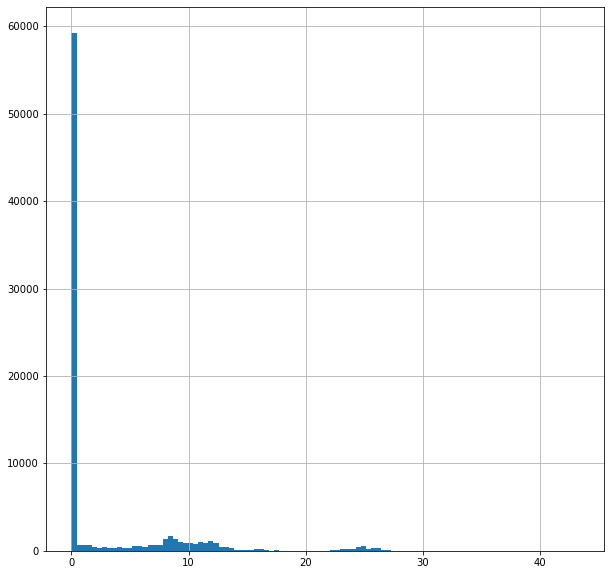

In [5]:
df['SOG'].hist(bins=100)

Let's get rid of these rows with zero SOG:

In [6]:
df = df[df.SOG>0]
print("Reduced to {} rows after removing 0 speed records".format(len(df)))

Reduced to 33593 rows after removing 0 speed records


Now, let's create trajectories:

In [7]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()

trajectories = []
for key, values in df.groupby(['MMSI']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
    #print(trajectory)
    trajectories.append(trajectory)

print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 77 trajectories in 0:00:06.383472


In [ ]:
my_traj = trajectories[0]
my_traj.df

In [ ]:
ZOOM_LEVEL = 13
my_traj.plot(with_basemap=True, linewidth=3.0, column='NavStatus', legend=True, 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Note: When plotting with basemap, you may run into missing map tiles. For Stamen, you can check map tile availability for a region and zoom level at http://maps.stamen.com/#terrain/15/57.6714/11.8120

Available tile sources are listed in https://github.com/darribas/contextily/blob/master/contextily/tile_providers.py, e.g.

```
ST_TONER = 'http://tile.stamen.com/toner/{z}/{x}/{y}.png'
ST_TONER_HYBRID = 'http://tile.stamen.com/toner-hybrid/{z}/{x}/{y}.png'
ST_TONER_LABELS = 'http://tile.stamen.com/toner-labels/{z}/{x}/{y}.png'
ST_TONER_LINES = 'http://tile.stamen.com/toner-lines/{z}/{x}/{y}.png'
ST_TONER_BACKGROUND = 'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'
ST_TONER_LITE = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

ST_TERRAIN = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
ST_TERRAIN_LABELS = 'http://tile.stamen.com/terrain-labels/{z}/{x}/{y}.png'
ST_TERRAIN_LINES = 'http://tile.stamen.com/terrain-lines/{z}/{x}/{y}.png'
ST_TERRAIN_BACKGROUND = 'http://tile.stamen.com/terrain-background/{z}/{x}/{y}.png'

ST_WATERCOLOR = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
```

More on plotting GeoPandas GeoDataframes: http://geopandas.org/gallery/plotting_basemap_background.html

## Finding ships passing under Älvsborgsbron bridge
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [ ]:
area_of_interest = Polygon([(11.89935, 57.69270), (11.90161, 57.68902), (11.90334, 57.68967), (11.90104, 57.69354), (11.89935, 57.69270)])

In [ ]:
intersections = []
for traj in trajectories:
    if traj.to_linestring().intersects(area_of_interest):
        intersections.append(traj)
print("Found {} intersections".format(len(intersections)))

In [ ]:
bridge_traj = intersections[0]
bridge_traj.plot(with_basemap=True, linewidth=3.0, column='NavStatus', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

In [ ]:
bridge_traj.df

## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [ ]:
trips = []
for traj in trajectories:
    for x in traj.split_by_observation_gap(timedelta(minutes=5)):
        if x.get_length() > MIN_LENGTH:
            trips.append(x)
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(trajectories)))

*Note: Splitting continous observations by observation gap is a straightforward way to extract individual trips. More sophisticated approaches require stop detection methods that do not require extended periods of time where the speed is at zero. MovingPandas so far does not implement such stop detection functions.*

Let's get the trip origins:

In [ ]:
origins = []
for trip in trips:
    origins.append({'geometry': trip.get_start_location(), 'id': trip.id, 
                    'SOG': trip.df.head(1)['SOG'][0], 'ShipType': trip.df.head(1)['ShipType'][0]})
origins = GeoDataFrame(pd.DataFrame(origins), crs=wgs84)

In [ ]:
ax = origins.to_crs(epsg=3857).plot(column='ShipType', legend=True)
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

In our data sample, trip origins can can be:
- When a ship departs it's anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

In [ ]:
ax = origins.to_crs(epsg=3857).plot(column='SOG', legend=True)
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

## Finding ships that depart from Sjöfartsverket (Maritime Administration)

In [ ]:
area_of_interest = Polygon([(11.86815, 57.68273), (11.86992, 57.68047), (11.87419, 57.68140), (11.87288, 57.68348), (11.86815, 57.68273)])

We can identify vessels that start their trip within a given area of interst by intersecting trip starting locations with our area of interest:

In [ ]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest):
        departures.append(traj)
print("Found {} departures".format(len(departures)))

In [ ]:
departures[1].plot(with_basemap=True, linewidth=3.0, column='NavStatus', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Let's see what kind of ships depart from here:

In [ ]:
for traj in departures:
    print("{} vessel '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Of course, the same works for arrivals:

In [ ]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest):
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} vessel '{}' arrived at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_end_time()))